In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import math

from keras.applications.mobilenet import MobileNet

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers

from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import time
from keras_preprocessing import image

import matplotlib.pylab as plt

# Download Dataset

## MIT Indoor Scenes Recognition by Using Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d itsahmad/indoor-scenes-cvpr-2019

100% 2.33G/2.34G [01:19<00:00, 118MB/s]
100% 2.34G/2.34G [01:19<00:00, 31.5MB/s]


In [ ]:
!unzip './indoor-scenes-cvpr-2019.zip'

Streaming output truncated to the last 5000 lines.
  inflating: indoorCVPR_09/Images/studiomusic/solarstudio.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio14.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio16.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio2.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio21.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio87.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio99.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_1.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_2.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_a.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_overall.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_pic_for_website.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studiomusic.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/susustudio.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/trabajo_238115785.jpg 

## MIT Indoor Scenes Recognition by Using Direct Web

In [ ]:
!wget "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar"

In [ ]:
!tar -xvf 'indoorCVPR_09.tar'

# Data Augmentation by Using Image Data Generator

In [ ]:
path_dir = '/content/indoorCVPR_09/Images'
# fix_categories=["airport_inside", "artstudio", "bathroom", "classroom", "computerroom"]
# fix_categories=["airport_inside", "artstudio", "bathroom", "classroom", "computerroom", "elevator", "greenhouse", "hospitalroom", "inside_bus", "kindergarden", "laboratorywet", "library", "locker_room", "museum", "office", "operating_room", "poolinside", "restaurant_kitchen", "studiomusic", "tv_studio", "waitingroom"]
fix_categories=["artstudio", "bathroom", "classroom", "computerroom", "elevator", "greenhouse", "hospitalroom", "inside_bus", "kindergarden", "laboratorywet", "library", "museum", "office", "operating_room", "poolinside", "restaurant_kitchen", "stairscase", "studiomusic", "tv_studio", "waitingroom"]
img_width = 224
img_height = 224
batch_size = 16
nb_epochs = 24
seed = 42

train_datagen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.05,
    zoom_range=0.2,
    brightness_range=[0.5, 1.0],
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.1) # set validation split

In [ ]:
# Train and Validation Generator
train_generator = train_datagen.flow_from_directory(
    path_dir,
    classes=fix_categories,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    path_dir, # same directory as training data
    classes=fix_categories,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset='validation') # set as validation data

Found 2350 images belonging to 20 classes.
Found 251 images belonging to 20 classes.


 # Visualization of Loss and Accuracy Value

In [ ]:
def graph():

  # History Variable
  print(history.history.keys())
  acc = history.history['accuracy']
  print(acc)
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, 'red', label='Training acc')
  plt.plot(epochs, val_acc, 'blue', label='Validation acc')
  plt.legend()

  plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, 'red', label='Training loss')
  plt.plot(epochs, val_loss, 'blue', label='Validation loss')

  plt.legend()
  plt.show()

# Evaluate Model Architecture

## Baseline Model

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(20, activation='softmax'))
# model.summary()

In [ ]:
baseline_save_path = "clf-baselinemodel-weights.hdf5"

In [ ]:
model.compile(Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 51, 51, 256)      

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=10
                             )
checkpointer = ModelCheckpoint(filepath=baseline_save_path, 
                               verbose=1, 
                               save_best_only=True
                              )
callbacks = [earlystopping, checkpointer]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=callbacks)

Epoch 1/24
146/146 [==============================] - 54s 361ms/step - loss: 2.9773 - accuracy: 0.0727 - val_loss: 2.8913 - val_accuracy: 0.1083

Epoch 00001: val_loss improved from inf to 2.89129, saving model to clf-baselinemodel-weights.hdf5
Epoch 2/24
146/146 [==============================] - 53s 360ms/step - loss: 2.8420 - accuracy: 0.1291 - val_loss: 2.7456 - val_accuracy: 0.1375

Epoch 00002: val_loss improved from 2.89129 to 2.74559, saving model to clf-baselinemodel-weights.hdf5
Epoch 3/24
146/146 [==============================] - 52s 356ms/step - loss: 2.7143 - accuracy: 0.1558 - val_loss: 2.6013 - val_accuracy: 0.2167

Epoch 00003: val_loss improved from 2.74559 to 2.60128, saving model to clf-baselinemodel-weights.hdf5
Epoch 4/24
146/146 [==============================] - 52s 357ms/step - loss: 2.6094 - accuracy: 0.2034 - val_loss: 2.6259 - val_accuracy: 0.2250

Epoch 00004: val_loss did not improve from 2.60128
Epoch 5/24
146/146 [==============================] - 52s 35

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.08740359544754028, 0.14824335277080536, 0.1808054894208908, 0.19494430720806122, 0.24164524674415588, 0.2832047939300537, 0.3093401789665222, 0.32862040400505066, 0.3487575054168701, 0.36718079447746277, 0.37789201736450195, 0.4134533107280731, 0.4211653769016266, 0.4383033514022827, 0.45415595173835754, 0.4755783975124359, 0.4991430938243866, 0.5304198861122131, 0.5467009544372559, 0.5424164533615112, 0.5951156616210938, 0.6015424132347107, 0.6246786713600159, 0.6418166160583496]


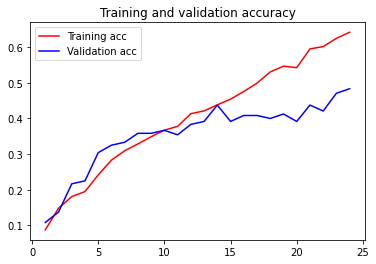

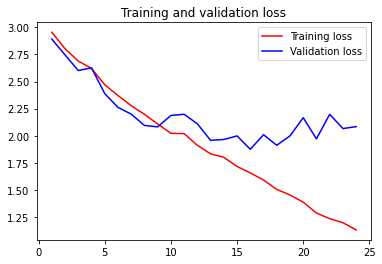

In [ ]:
graph()

In [ ]:
_, acc = model.evaluate(train_generator)
print("Training accuracy : {} %".format(acc*100))

_, acc = model.evaluate(validation_generator)
print("Validation accuracy : {} %".format(acc*100))

147/147 [==============================] - 42s 287ms/step - loss: 0.9703 - accuracy: 0.6996
Training accuracy : 69.95744705200195 %
16/16 [==============================] - 8s 509ms/step - loss: 2.2066 - accuracy: 0.4343
Validation accuracy : 43.42629611492157 %


## MobileNet Transfer Learning

In [ ]:
mobile_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(len(mobile_model.layers))
mobile_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
86
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________

In [ ]:
model = Sequential()
model.add(mobile_model)
model.add(AveragePooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))

model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 3,763,924
Trainable params: 3,742,036
Non-trainable params: 21,888
_________________________________________

In [ ]:
mobilenet_save_path = "clf-mobilenet-weights.hdf5"

In [ ]:
model.compile(Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=10
                             )
checkpointer = ModelCheckpoint(filepath=mobilenet_save_path, 
                               verbose=1, 
                               save_best_only=True
                              )
callbacks = [earlystopping, checkpointer]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=callbacks)

Epoch 1/24
146/146 [==============================] - 103s 357ms/step - loss: 2.6956 - accuracy: 0.2315 - val_loss: 1.5240 - val_accuracy: 0.5333

Epoch 00001: val_loss improved from inf to 1.52404, saving model to clf-mobilenet-weights.hdf5
Epoch 2/24
146/146 [==============================] - 50s 342ms/step - loss: 1.2314 - accuracy: 0.6414 - val_loss: 1.1781 - val_accuracy: 0.6500

Epoch 00002: val_loss improved from 1.52404 to 1.17805, saving model to clf-mobilenet-weights.hdf5
Epoch 3/24
146/146 [==============================] - 50s 342ms/step - loss: 0.7999 - accuracy: 0.7518 - val_loss: 1.0011 - val_accuracy: 0.6792

Epoch 00003: val_loss improved from 1.17805 to 1.00108, saving model to clf-mobilenet-weights.hdf5
Epoch 4/24
146/146 [==============================] - 50s 341ms/step - loss: 0.6101 - accuracy: 0.8129 - val_loss: 0.9077 - val_accuracy: 0.7208

Epoch 00004: val_loss improved from 1.00108 to 0.90770, saving model to clf-mobilenet-weights.hdf5
Epoch 5/24
146/146 [===

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.3607540726661682, 0.6529563069343567, 0.7609254717826843, 0.8127678036689758, 0.8688945770263672, 0.895458459854126, 0.9104541540145874, 0.9361611008644104, 0.9408740401268005, 0.9515852332115173, 0.9631533622741699, 0.967009425163269, 0.9695801138877869, 0.9674378633499146, 0.9790059924125671, 0.9764353036880493, 0.9798628687858582, 0.9837189316749573]


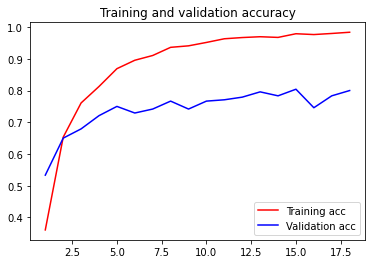

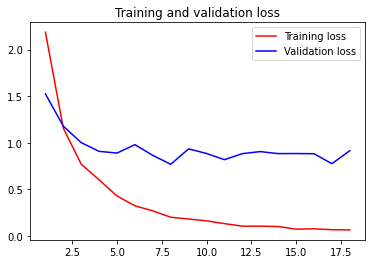

In [ ]:
graph()

In [ ]:
_, acc = model.evaluate(train_generator)
print("Training accuracy : {} %".format(acc*100))

_, acc = model.evaluate(validation_generator)
print("Validation accuracy : {} %".format(acc*100))

147/147 [==============================] - 42s 283ms/step - loss: 0.0285 - accuracy: 0.9911
Training accuracy : 99.10638332366943 %
16/16 [==============================] - 6s 397ms/step - loss: 0.9528 - accuracy: 0.7809
Validation accuracy : 78.08765172958374 %


In [ ]:
model.save(mobilenet_save_path)

# Testing Model

Saving bathroom2.jpg to bathroom2.jpg
--- 0.03707098960876465 seconds ---


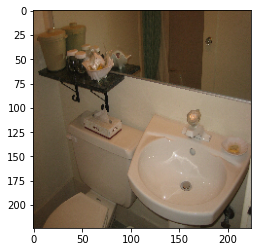

bathroom: 100.00%
museum: 0.00%
stairscase: 0.00%
poolinside: 0.00%
tv_studio: 0.00%
restaurant_kitchen: 0.00%
studiomusic: 0.00%
operating_room: 0.00%
elevator: 0.00%
hospitalroom: 0.00%
artstudio: 0.00%
waitingroom: 0.00%
greenhouse: 0.00%
classroom: 0.00%
laboratorywet: 0.00%
office: 0.00%
library: 0.00%
inside_bus: 0.00%
computerroom: 0.00%
kindergarden: 0.00%


In [ ]:
import time
# from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras_preprocessing import image

labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for upload in uploaded.keys():
  path = upload
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  start_time = time.time()

  images = np.vstack([x])
  proba = list(model.predict(images)[0])
  print("--- %s seconds ---" % (time.time() - start_time))

  plt.imshow(img)
  plt.show()

  zip_result = []
  for z in range(len(labels)):
    zip_result.append([labels[z], proba[z]])

  sorted_zip_result = sorted(zip_result, key=lambda tup: tup[1], reverse=True)

  for x in range(len(sorted_zip_result)):
    print("{}: {:.2f}%".format(sorted_zip_result[x][0], sorted_zip_result[x][1] * 100))

# Convert Model to TensorFlow Lite

In [ ]:
import tensorflow as tf

# Load the model
model_lite = tf.keras.models.load_model(filepath=save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_lite)
tflite_model = converter.convert()

# Save the TF Lite model
with tf.io.gfile.GFile('clf-mobilenet-weights20.tflite', 'wb') as f:
  f.write(tflite_model)